# Getting the data

Link to kaggle dataset: [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data)


In [158]:
# Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine

# Create a Relational Database

In [159]:
# Load CSV file into SQLite database

data = pd.read_csv("healthcare-dataset-stroke-data.csv")

# Establish a SQLite connection and create a databse
conn = sqlite3.connect("stroke_data.db")
data.to_sql('stroke_data', conn, if_exists='replace', index=False)

# Create a cursor
cursor = conn.cursor()

In [160]:
# Describe the table in the database

cursor.execute("PRAGMA table_info(stroke_data);")
cursor.fetchall()

[(0, 'id', 'INTEGER', 0, None, 0),
 (1, 'gender', 'TEXT', 0, None, 0),
 (2, 'age', 'REAL', 0, None, 0),
 (3, 'hypertension', 'INTEGER', 0, None, 0),
 (4, 'heart_disease', 'INTEGER', 0, None, 0),
 (5, 'ever_married', 'TEXT', 0, None, 0),
 (6, 'work_type', 'TEXT', 0, None, 0),
 (7, 'Residence_type', 'TEXT', 0, None, 0),
 (8, 'avg_glucose_level', 'REAL', 0, None, 0),
 (9, 'bmi', 'REAL', 0, None, 0),
 (10, 'smoking_status', 'TEXT', 0, None, 0),
 (11, 'stroke', 'INTEGER', 0, None, 0)]

# Data Cleaning

In [161]:
def run_query(query):
    rows = cursor.execute(query)
    
    for row in rows:
        result = print(row)
    return result

In [162]:
# Check the table for missing an incocnsistent values

query = '''
SELECT * 
FROM stroke_data
WHERE 
    -- Check for missing values
    gender IS NULL OR 
    age IS NULL OR 
    hypertension IS NULL OR 
    heart_disease IS NULL OR 
    ever_married IS NULL OR 
    work_type IS NULL OR 
    residence_type IS NULL OR 
    avg_glucose_level IS NULL OR 
    bmi IS NULL OR 
    smoking_status IS NULL OR 
    stroke IS NULL OR 

    -- Check for inconsistent values
    gender NOT IN ('Male', 'Female', 'Other') OR 
    age < 0 OR 
    hypertension NOT IN (0, 1) OR 
    heart_disease NOT IN (0, 1) OR 
    ever_married NOT IN ('Yes', 'No') OR 
    work_type NOT IN ('Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked') OR 
    residence_type NOT IN ('Urban', 'Rural') OR 
    avg_glucose_level <= 0 OR 
    bmi <= 0 OR 
    smoking_status NOT IN ('never smoked', 'formerly smoked', 'smokes', 'Unknown') OR 
    stroke NOT IN (0, 1);
'''

run_query(query)


(51676, 'Female', 61.0, 0, 0, 'Yes', 'Self-employed', 'Rural', 202.21, None, 'never smoked', 1)
(27419, 'Female', 59.0, 0, 0, 'Yes', 'Private', 'Rural', 76.15, None, 'Unknown', 1)
(8213, 'Male', 78.0, 0, 1, 'Yes', 'Private', 'Urban', 219.84, None, 'Unknown', 1)
(25226, 'Male', 57.0, 0, 1, 'No', 'Govt_job', 'Urban', 217.08, None, 'Unknown', 1)
(61843, 'Male', 58.0, 0, 0, 'Yes', 'Private', 'Rural', 189.84, None, 'Unknown', 1)
(69160, 'Male', 59.0, 0, 0, 'Yes', 'Private', 'Rural', 211.78, None, 'formerly smoked', 1)
(1845, 'Female', 63.0, 0, 0, 'Yes', 'Private', 'Urban', 90.9, None, 'formerly smoked', 1)
(37937, 'Female', 75.0, 0, 1, 'No', 'Self-employed', 'Urban', 109.78, None, 'Unknown', 1)
(18587, 'Female', 76.0, 0, 0, 'No', 'Private', 'Urban', 89.96, None, 'Unknown', 1)
(15102, 'Male', 78.0, 1, 0, 'Yes', 'Private', 'Urban', 75.32, None, 'formerly smoked', 1)
(8752, 'Female', 63.0, 0, 0, 'Yes', 'Govt_job', 'Urban', 197.54, None, 'never smoked', 1)
(66400, 'Male', 78.0, 0, 0, 'Yes', 'Pr

In [163]:
# Clean the missing bmi values using mean

query = '''
UPDATE stroke_data
SET bmi = (
        SELECT AVG(bmi) 
        FROM stroke_data 
        WHERE bmi IS NOT NULL
        )
WHERE bmi IS NULL;
'''

cursor.execute(query)

# Explore Data Using SQL

In [164]:
# What is the stroke frequency

query = ''' 
SELECT 
    stroke, 
    COUNT(*) AS total_patients, 
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM stroke_data), 2) AS percentage
FROM stroke_data
GROUP BY stroke;
'''

run_query(query)

(0, 4861, 95.13)
(1, 249, 4.87)


In [165]:
# Identify which age brackets are most vulnerable to strokes:

query = ''' 
SELECT 
    CASE 
        WHEN age < 30 THEN 'Under 30'
        WHEN age BETWEEN 30 AND 50 THEN '30-50'
        WHEN age BETWEEN 51 AND 70 THEN '51-70'
        ELSE 'Above 70'
    END AS age_group,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY age_group
ORDER BY     
    CASE 
        WHEN age < 30 THEN 1
        WHEN age BETWEEN 30 AND 50 THEN 2
        WHEN age BETWEEN 51 AND 70 THEN 3
        ELSE 4
    END;
'''

run_query(query)

('Under 30', 1515, 2, 0.13)
('30-50', 1468, 21, 1.43)
('51-70', 1417, 98, 6.92)
('Above 70', 710, 128, 18.03)


In [166]:
# Investigate any gender-specific differences in stroke occurances:

query = ''' 
SELECT 
    gender,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY gender;
'''

run_query(query)

('Female', 2994, 141, 4.71)
('Male', 2115, 108, 5.11)
('Other', 1, 0, 0.0)


In [167]:
# Explore whether environmentl factors (such as living in urban areas vs rural) influence stroke risk:

query = ''' 
SELECT 
    Residence_type,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY Residence_type;
'''

run_query(query)

('Rural', 2514, 114, 4.53)
('Urban', 2596, 135, 5.2)


In [168]:
# Explore the impact of high blood pressure on stroke likelihood

query = ''' 
SELECT 
    hypertension,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY hypertension;
'''

run_query(query)

(0, 4612, 183, 3.97)
(1, 498, 66, 13.25)


In [169]:
# Explore the correlation between heart disease and stroke

query = ''' 
SELECT 
    heart_disease,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY heart_disease;
'''

run_query(query)

(0, 4834, 202, 4.18)
(1, 276, 47, 17.03)


In [170]:
# Explore the influence bmi has on stroke risks

query = ''' 
SELECT 
    CASE 
        WHEN bmi < 18.5 THEN 'Underweight'
        WHEN bmi BETWEEN 18.5 AND 24.9 THEN 'Normal'
        WHEN bmi BETWEEN 25 AND 29.9 THEN 'Overweight'
        ELSE 'Obese'
    END AS bmi_category,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY bmi_category
ORDER BY 
    CASE 
        WHEN bmi < 18.5 THEN 1
        WHEN bmi BETWEEN 18.5 AND 24.9 THEN 2
        WHEN bmi BETWEEN 25 AND 29.9 THEN 3
        ELSE 4
    END;
'''

run_query(query)

('Underweight', 337, 1, 0.3)
('Normal', 1243, 35, 2.82)
('Overweight', 1610, 115, 7.14)
('Obese', 1920, 98, 5.1)


In [171]:
# Explore how glucose levels influence stroke risks:

query = ''' 
SELECT 
    CASE 
        WHEN avg_glucose_level < 100 THEN 'Normal'
        WHEN avg_glucose_level BETWEEN 100 AND 125 THEN 'Prediabetic'
        ELSE 'Diabetic'
    END AS glucose_category,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY glucose_category
ORDER BY
    CASE 
        WHEN avg_glucose_level < 100 THEN 1
        WHEN avg_glucose_level BETWEEN 100 AND 125 THEN 2
        ELSE 3
    END;
'''

run_query(query)

('Normal', 3131, 112, 3.58)
('Prediabetic', 979, 37, 3.78)
('Diabetic', 1000, 100, 10.0)


In [172]:
# Explore how smoking impacts stroke risk:

query = ''' 
SELECT 
    smoking_status,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY smoking_status;
'''

run_query(query)

print()

# Group patients who smoke and formerly smoked into one Smoker category to better compare results to Non-Smokers
query = ''' 
SELECT 
    CASE 
        WHEN smoking_status IN ('smokes', 'formerly smoked') THEN 'Smoker'
        ELSE 'Non-Smoker'
    END AS smoking_category,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_probability
FROM 
    stroke_data
GROUP BY 
    smoking_category;
'''

run_query(query)

('Unknown', 1544, 47, 3.04)
('formerly smoked', 885, 70, 7.91)
('never smoked', 1892, 90, 4.76)
('smokes', 789, 42, 5.32)

('Non-Smoker', 3436, 137, 3.99)
('Smoker', 1674, 112, 6.69)


In [173]:
# Explore how being married influences stroke risk:

query = ''' 
SELECT 
    ever_married,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY ever_married;
'''

run_query(query)

('No', 1757, 29, 1.65)
('Yes', 3353, 220, 6.56)


In [174]:
# Explore which type of employment is associated with higher stroke rate:

query = ''' 
SELECT 
    work_type,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY work_type
ORDER BY stroke_rate DESC;
'''

run_query(query)

('Self-employed', 819, 65, 7.94)
('Private', 2925, 149, 5.09)
('Govt_job', 657, 33, 5.02)
('children', 687, 2, 0.29)
('Never_worked', 22, 0, 0.0)


In [175]:
# Explore the combined effect of age and hypertension on stroke risk:

query = ''' 
SELECT 
    CASE 
        WHEN age < 30 THEN 'Under 30'
        WHEN age BETWEEN 30 AND 50 THEN '30-50'
        WHEN age BETWEEN 51 AND 70 THEN '51-70'
        ELSE 'Above 70'
    END AS age_group,
    hypertension,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY age_group, hypertension
ORDER BY 
    CASE 
        WHEN age < 30 THEN 1
        WHEN age BETWEEN 30 AND 50 THEN 2
        WHEN age BETWEEN 51 AND 70 THEN 3
        ELSE 4
    END,
    hypertension;
'''

run_query(query)

('Under 30', 0, 1504, 2, 0.13)
('Under 30', 1, 11, 0, 0.0)
('30-50', 0, 1384, 18, 1.3)
('30-50', 1, 84, 3, 3.57)
('51-70', 0, 1187, 74, 6.23)
('51-70', 1, 230, 24, 10.43)
('Above 70', 0, 537, 89, 16.57)
('Above 70', 1, 173, 39, 22.54)


In [176]:
# Explore the combined influence of smoking and glucose levels on stroke risk:

query = ''' 
SELECT 
    CASE 
        WHEN smoking_status IN ('smokes', 'formerly smoked') THEN 'Smoker'
        ELSE 'Non-Smoker'
    END AS smoking_category,
    CASE 
        WHEN avg_glucose_level < 100 THEN 'Normal'
        WHEN avg_glucose_level BETWEEN 100 AND 125 THEN 'Prediabetic'
        ELSE 'Diabetic'
    END AS glucose_category,
    COUNT(*) AS total_patients,
    SUM(stroke) AS total_strokes,
    ROUND(SUM(stroke) * 100.0 / COUNT(*), 2) AS stroke_rate
FROM stroke_data
GROUP BY smoking_category, glucose_category;
'''

run_query(query)

('Non-Smoker', 'Diabetic', 623, 54, 8.67)
('Non-Smoker', 'Normal', 2147, 68, 3.17)
('Non-Smoker', 'Prediabetic', 666, 15, 2.25)
('Smoker', 'Diabetic', 377, 46, 12.2)
('Smoker', 'Normal', 984, 44, 4.47)
('Smoker', 'Prediabetic', 313, 22, 7.03)


In [177]:
# Load cleaned data from database into pandas dataframe for visualization

query = "SELECT * FROM stroke_data;"  # Replace with your actual table name
data = pd.read_sql(query, conn)


# Close the connection
conn.close()


# Data Visualization

Stroke Rate: 4.87%


/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/3031261168.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['No Stroke', 'Stroke'], y=[100 - stroke_rate, stroke_rate], palette="coolwarm")


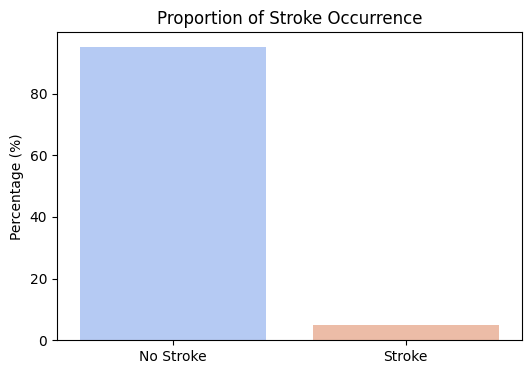

In [178]:
# Stroke rate as a proportion
stroke_rate = data['stroke'].mean() * 100
print(f"Stroke Rate: {stroke_rate:.2f}%")

# Visualize
plt.figure(figsize=(6, 4))
sns.barplot(x=['No Stroke', 'Stroke'], y=[100 - stroke_rate, stroke_rate], palette="coolwarm")
plt.title("Proportion of Stroke Occurrence")
plt.ylabel("Percentage (%)")
plt.show()

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/1180363675.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_stroke = data.groupby('age_group')['stroke'].mean().reset_index()
/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/1180363675.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_group_stroke, x='age_group', y='stroke', palette="viridis")


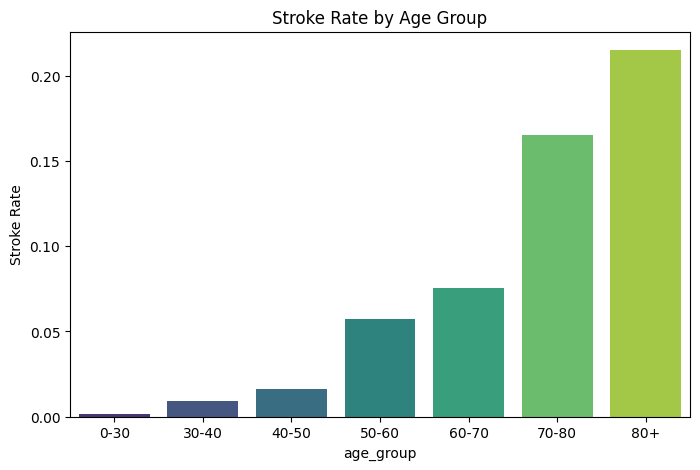

In [179]:
# Stroke rate by age group

# Define age bins and labels
age_bins = [0, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['0-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']

# Create age_group column
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

age_group_stroke = data.groupby('age_group')['stroke'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=age_group_stroke, x='age_group', y='stroke', palette="viridis")
plt.title("Stroke Rate by Age Group")
plt.ylabel("Stroke Rate")
plt.show()

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/1334720525.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hypertension_rate, x='hypertension', y='stroke', palette="muted")


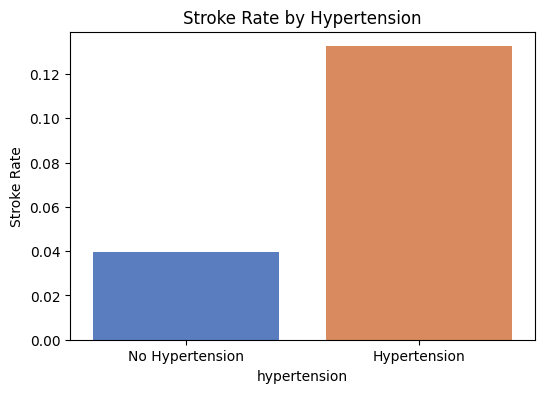

In [180]:
# Stroke rate by hypertension
hypertension_rate = data.groupby('hypertension')['stroke'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=hypertension_rate, x='hypertension', y='stroke', palette="muted")
plt.title("Stroke Rate by Hypertension")
plt.xticks([0, 1], ['No Hypertension', 'Hypertension'])
plt.ylabel("Stroke Rate")
plt.show()

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/4173492617.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=heart_disease_rate, x='heart_disease', y='stroke', palette="muted")


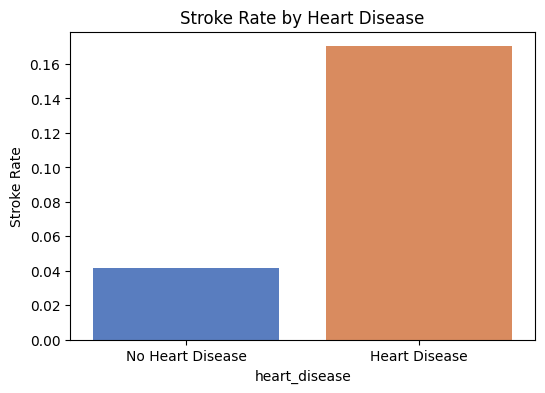

In [181]:
# Stroke rate by heart disease
heart_disease_rate = data.groupby('heart_disease')['stroke'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=heart_disease_rate, x='heart_disease', y='stroke', palette="muted")
plt.title("Stroke Rate by Heart Disease")
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease'])
plt.ylabel("Stroke Rate")
plt.show()

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/2896431349.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  glucose_rate = data.groupby('glucose_group')['stroke'].mean().reset_index()
/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/2896431349.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=glucose_rate, x='glucose_group', y='stroke', palette="coolwarm")


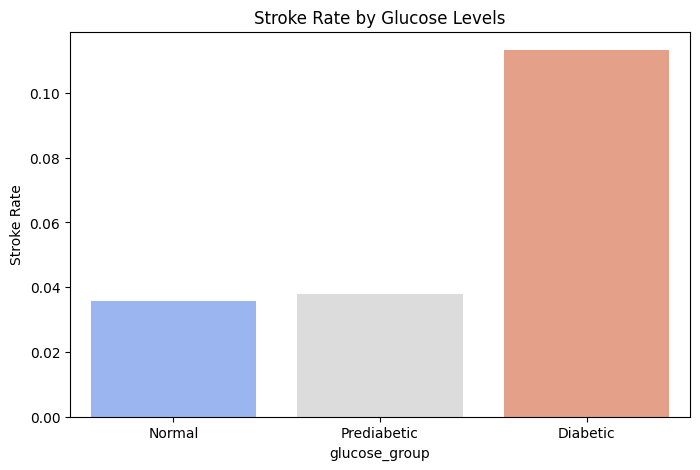

In [182]:
# Group glucose into categories
data['glucose_group'] = pd.cut(data['avg_glucose_level'], bins=[0, 100, 140, 300], 
                               labels=['Normal', 'Prediabetic', 'Diabetic'])

# Stroke rate by glucose group
glucose_rate = data.groupby('glucose_group')['stroke'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=glucose_rate, x='glucose_group', y='stroke', palette="coolwarm")
plt.title("Stroke Rate by Glucose Levels")
plt.ylabel("Stroke Rate")
plt.show()

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/3666418075.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_rate = data.groupby('bmi_group')['stroke'].mean().reset_index()
/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/3666418075.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bmi_rate, x='bmi_group', y='stroke', palette="viridis")


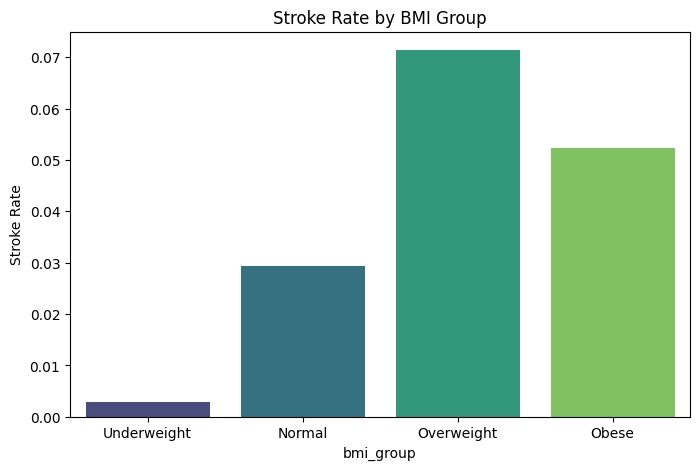

In [183]:
# Group BMI into categories
data['bmi_group'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, 50], 
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Stroke rate by BMI group
bmi_rate = data.groupby('bmi_group')['stroke'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=bmi_rate, x='bmi_group', y='stroke', palette="viridis")
plt.title("Stroke Rate by BMI Group")
plt.ylabel("Stroke Rate")
plt.show()

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/3871348636.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=smoking_rate, x='smoking_status', y='stroke', palette="muted")


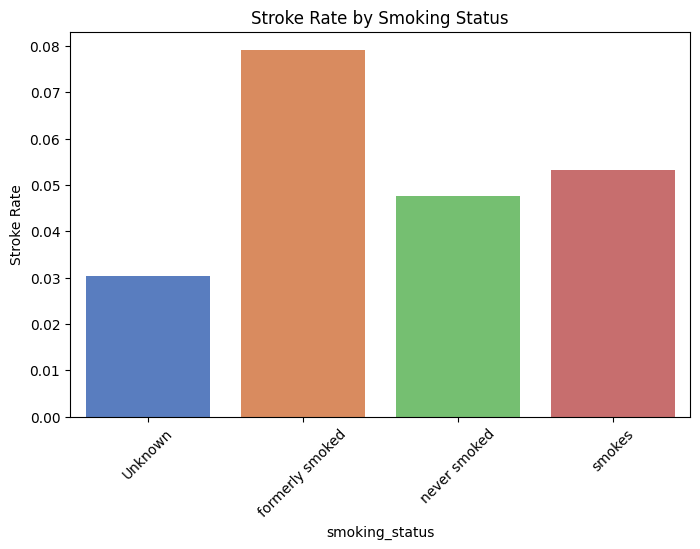

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/3871348636.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=smoker_rate, x='smoker_group', y='stroke', palette="coolwarm")


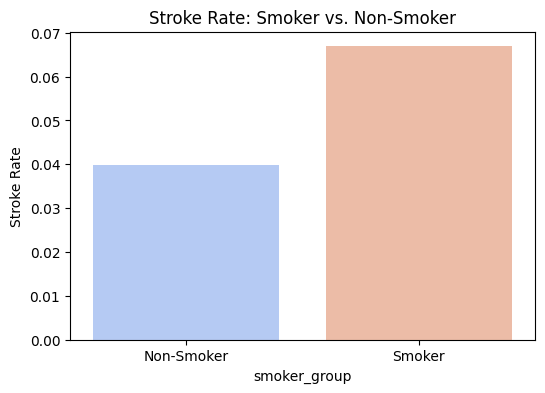

In [184]:
# Stroke rate by smoking status
smoking_rate = data.groupby('smoking_status')['stroke'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=smoking_rate, x='smoking_status', y='stroke', palette="muted")
plt.title("Stroke Rate by Smoking Status")
plt.ylabel("Stroke Rate")
plt.xticks(rotation=45)
plt.show()


# Combine smoking categories into 'Smoker' and 'Non-Smoker'
data['smoker_group'] = data['smoking_status'].apply(lambda x: 'Smoker' if x in ['formerly smoked', 'smokes'] else 'Non-Smoker')

# Stroke rate by Smoker vs. Non-Smoker
smoker_rate = data.groupby('smoker_group')['stroke'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=smoker_rate, x='smoker_group', y='stroke', palette="coolwarm")
plt.title("Stroke Rate: Smoker vs. Non-Smoker")
plt.ylabel("Stroke Rate")
plt.show()

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/4174190966.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_hypertension = data.groupby(['age_group', 'hypertension'])['stroke'].mean().reset_index()


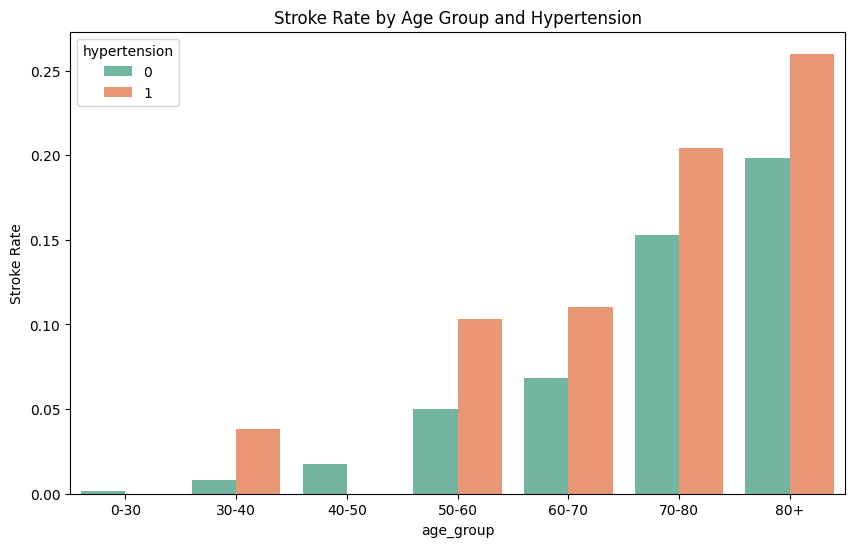

In [185]:
# Combine age group and hypertension
age_hypertension = data.groupby(['age_group', 'hypertension'])['stroke'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=age_hypertension, x='age_group', y='stroke', hue='hypertension', palette="Set2")
plt.title("Stroke Rate by Age Group and Hypertension")
plt.ylabel("Stroke Rate")
plt.show()

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/4112235119.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  smoking_glucose = data.groupby(['smoking_status', 'glucose_group'])['stroke'].mean().reset_index()


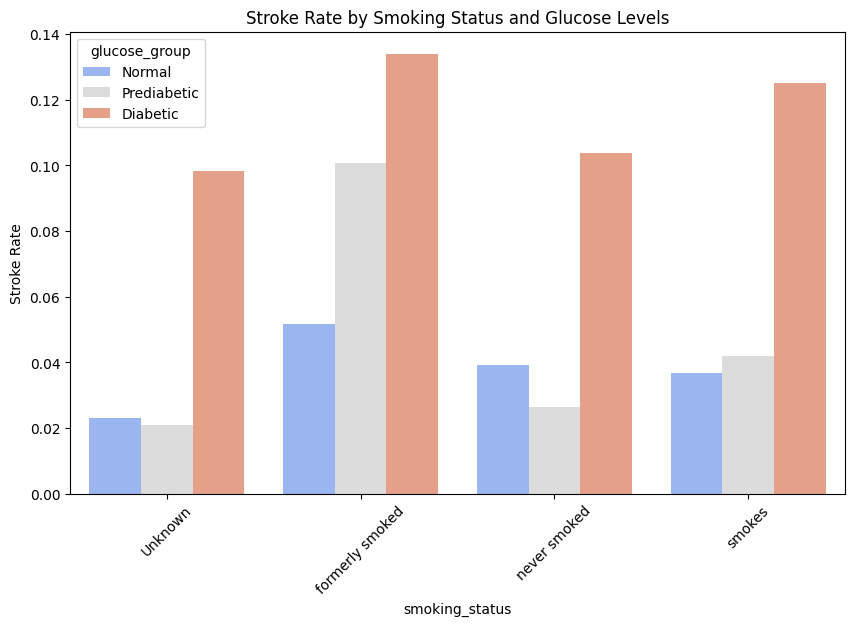

/var/folders/kq/r91n3pg50f52jw0_9dcxyx280000gn/T/ipykernel_7046/4112235119.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  smoking_glucose = data.groupby(['smoker_group', 'glucose_group'])['stroke'].mean().reset_index()


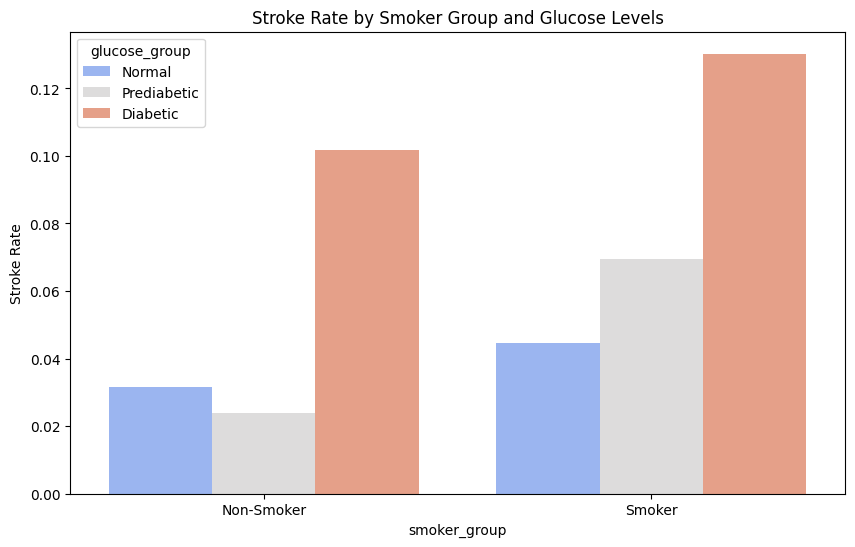

In [186]:
# Combine smoking and glucose group
smoking_glucose = data.groupby(['smoking_status', 'glucose_group'])['stroke'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=smoking_glucose, x='smoking_status', y='stroke', hue='glucose_group', palette="coolwarm")
plt.title("Stroke Rate by Smoking Status and Glucose Levels")
plt.ylabel("Stroke Rate")
plt.xticks(rotation=45)
plt.show()


# Segment by Smoker vs. Non-Smoker and glucose levels
smoking_glucose = data.groupby(['smoker_group', 'glucose_group'])['stroke'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=smoking_glucose, x='smoker_group', y='stroke', hue='glucose_group', palette="coolwarm")
plt.title("Stroke Rate by Smoker Group and Glucose Levels")
plt.ylabel("Stroke Rate")
plt.show()

# Machine Learning

In [187]:
# Import required libraries for modeling

from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [188]:
# Prepare Data for Modeling
target = 'stroke'  # Column indicating stroke presence (1 or 0)
y = data[target]
X = data.drop(columns=[target, 'id'])

# Automatically select categorical columns (object or category dtype)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Define transformations for each column type
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Create a pipeline that first transforms the data and then fits a Logistic Regression model
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression Model
log_reg_pipeline.fit(X_train, y_train)

# Make Predictions
y_pred = log_reg_pipeline.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Model Accuracy: 73.58%
Confusion Matrix:
[[699 261]
 [  9  53]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       960
           1       0.17      0.85      0.28        62

    accuracy                           0.74      1022
   macro avg       0.58      0.79      0.56      1022
weighted avg       0.94      0.74      0.80      1022

